In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.signal import savgol_filter
from tqdm import tqdm

from pelenet.utils import Utils
from pelenet.experiments.readoutrandom import ReadoutRandomExperiment
from pelenet.experiments.readout import ReadoutExperiment

In [54]:
# Initilizes utils
utils = Utils.instance()

In [55]:
# load data
sExRand = np.load('data/comparison/spikes_ex-random.npy')
sOutRand = np.load('data/comparison/spikes_out-random.npy')
sExAniso = np.load('data/comparison/spikes_ex-anisotropic.npy')
sOutAniso = np.load('data/comparison/spikes_out-anisotropic.npy')

In [56]:
# Matplotlib parameters
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.family'] = 'CMU Sans Serif'
plt.rcParams['font.size'] = 14

In [57]:
def readParameters():
    exp = ReadoutExperiment()
    return exp.p

p = readParameters()

# Spike trains and firing rates

In [6]:
def concatenateSpikes(data, nTrials):
    spiketrain = np.hstack([np.concatenate((data[i], np.zeros((p.reservoirExSize,20))), axis=1) for i in range(nTrials)])
    rates = np.mean(spiketrain, axis=0)
    return spiketrain, rates

In [17]:
def plotSpikeTrain(spiketrain, color, name):
    # Define colors
    cmap = colors.ListedColormap(['#ffffff', color])

    # Plot spike train
    plt.figure(figsize=(10,6))
    plt.imshow(spiketrain, cmap=cmap, aspect='auto')
    #plt.title('Reservoir spikes')
    plt.xlabel('time steps')
    plt.ylabel('index of neuron')
    plt.xlim((0,spiketrain.shape[1]))
    plt.savefig('plots/figure5/spiketrain_'+name+'.svg')
    pl = plt.show()
    
def plotSpikeRates(spikerates, color, name):
    plt.figure(figsize=(10,2))
    plt.plot(spikerates, color=color)
    plt.ylabel('mean firing rate')
    plt.ylim((0,0.25))
    plt.xlabel('time steps')
    plt.xlim((0,len(spikerates)))
    plt.savefig('plots/figure5/spikerates_'+name+'.svg')
    pl = plt.show()

In [8]:
spiketrainRand, ratesRand = concatenateSpikes(sExRand[:,:,:200], 3)
spiketrainAniso, ratesAniso = concatenateSpikes(sExAniso[:,:,:200], 3)

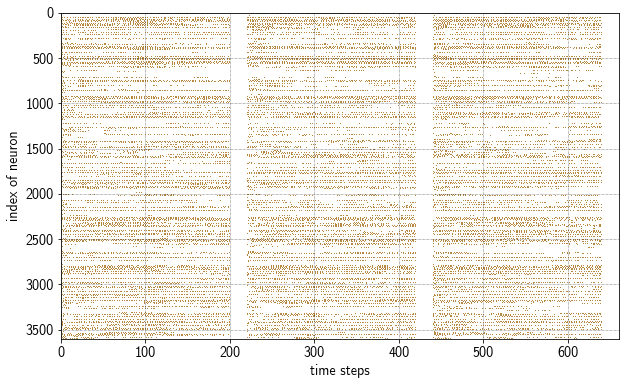

In [11]:
plotSpikeTrain(spiketrainRand, p.pltColor4, 'random')

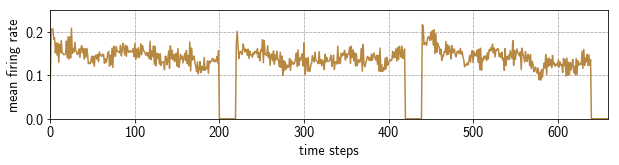

In [18]:
plotSpikeRates(ratesRand, p.pltColor4, 'random')

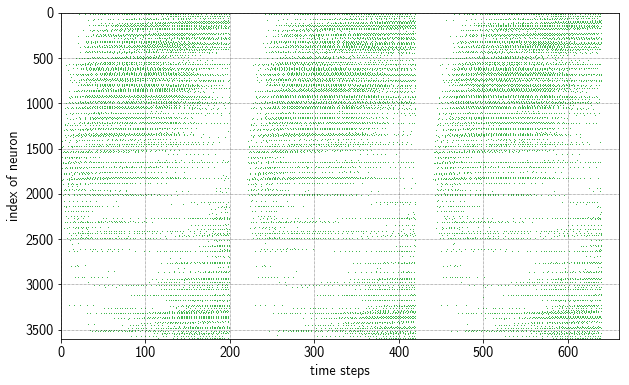

In [13]:
plotSpikeTrain(spiketrainAniso, p.pltColor3, 'anisotropic')

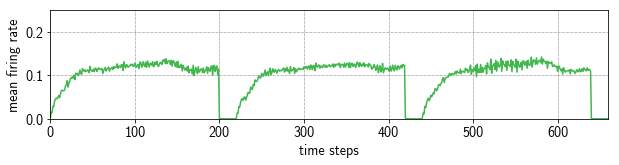

In [19]:
plotSpikeRates(ratesAniso, p.pltColor3, 'anisotropic')

# Differences between trials

Shows mean difference between trials. The single differences are normed with the number of neurons devided by the refractory period (with 3600 neurons and refractory period of 2, we expect maximum 1800 neurons to be active).

In [121]:
def calcTrialDiffs(data):
    diffs = []
    for i in range(p.trials):
        for j in range(p.trials):
            if i > j:
                # Get difference between data, devide by number of neurons
                diff = np.abs(data[i] - data[j])
                # Mean over neurons
                #norm = data.shape[1]/p.refractoryDelay
                norm = (np.sum(data[i] + data[j], axis=0))/2
                diff_mean = np.sum(diff, axis=0)/norm
                # Append to list
                diffs.append(diff_mean)
    
    # Make numpy array and return
    return np.array(diffs)

In [126]:
def plotDiffMean(diffsRand, diffsAniso):
    """
    Random network
    """
    # Calculate mean and standard deviation
    mr = np.mean(np.array(diffsRand), axis=0)
    sr = np.std(np.array(diffsRand), axis=0)
    # Plot mean
    plt.plot(mr, color=p.pltColor4, linewidth=2.0, label='Random')
    # Plot standard deviation around mean
    plt.fill_between(np.arange(210), mr-sr, mr+sr, color=p.pltColor4, alpha=0.5)
    
    """
    Anisotropic network
    """
    # Calculate mean and standard deviation
    ma = np.mean(np.array(diffsAniso), axis=0)
    sa = np.std(np.array(diffsAniso), axis=0)
    # Plot mean
    plt.plot(ma, color=p.pltColor3, linewidth=2.0, label='Anisotropic')
    # Plot standard deviation around mean
    plt.fill_between(np.arange(210), ma-sa, ma+sa, color=p.pltColor3, alpha=0.5)

    #plt.legend()
    plt.xlim(0,200)
    #plt.ylim(0,0.8)
    plt.xlabel('time steps')
    plt.ylabel('mean deviation between trials')
    # Save and show plot
    plt.savefig('plots/figure5/trialdiffs.svg')
    pl = plt.show()

In [122]:
diffsRand = calcTrialDiffs(sExRand)
diffsAniso = calcTrialDiffs(sExAniso)

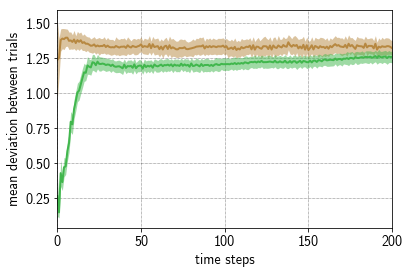

In [127]:
plotDiffMean(diffsRand, diffsAniso)

# PCA

In [38]:
# Bin spiking data
binSize = 10

def getBinnedSpikes(data):
    return np.array([np.mean(data[:, :, i:i+binSize], axis=2) for i in range(0,data.shape[2],binSize)])

def pcaAllTrials(bins):
    dtrans = []
    for i in tqdm(range(p.trials)):
        (d, evals, evecs) = utils.pca(bins[:,i,:].astype(float), dims_rescaled_data=2)
        dtrans.append(d)
        
    return np.array(dtrans)

def plotPca1d(pc, color, name):
    for i in range(p.trials):
        plt.plot(np.arange(0,p.stepsPerTrial,binSize), pc[i,:,0], linewidth=0.5, color=color)
    plt.xlabel('time steps')
    plt.savefig('plots/figure5/pca1d_'+name+'.svg')
    pl = plt.show()

def plotPca2d(pc, color, name):
    #plt.figure(figsize=(10,4))
    plt.figure(figsize=(8,6))
    ax = plt.axes(projection='3d')
    for i in range(p.trials):
        ax.plot3D(np.arange(0,p.stepsPerTrial,binSize), pc[i,:,0], pc[i,:,1], linewidth=0.5, color=color)
    ax.view_init(20,285)
    #ax.set_yticks([])
    #ax.set_zticks([])
    plt.xlim(0,200)
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    #ax.set_xlabel('time steps', labelpad=40)
    ax.set_xlabel('time steps', labelpad=20)
    ax.set_ylabel('PC1', labelpad=-5)
    ax.set_zlabel('PC2', labelpad=-5)
    #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.5, 0.8, 1]))  # scale_x, scale_y, scale_z, 1
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.8, 0.8, 1]))  # scale_x, scale_y, scale_z, 1
    plt.savefig('plots/figure5/pca2d_'+name+'.svg')
    pl = plt.show()

In [26]:
# Calculate bins
bExRand = getBinnedSpikes(sExRand)
bExAniso = getBinnedSpikes(sExAniso)

In [27]:
# Get first two pca components
p2ExRand = pcaAllTrials(bExRand)
p2ExAniso = pcaAllTrials(bExAniso)

100%|██████████| 25/25 [02:47<00:00,  6.70s/it]


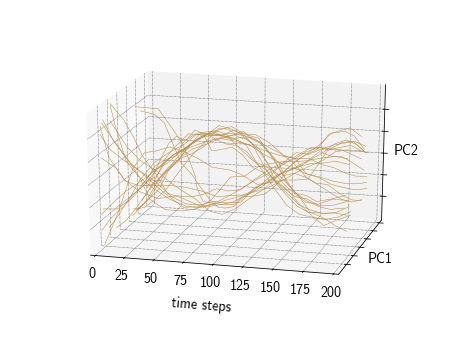

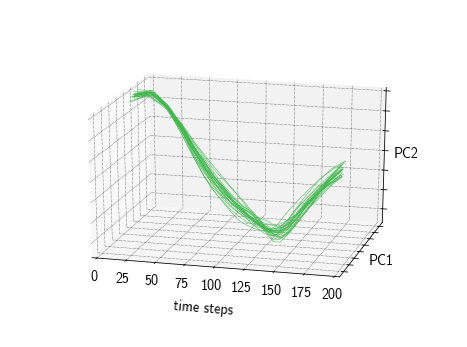

In [60]:
plotPca2d(p2ExRand, p.pltColor4, 'random')
plotPca2d(p2ExAniso, p.pltColor3, 'anisotropic')

# Multiple trajectories output learning

* 0 Random - Representation - Reservoir
* 1 Random - Representation - Pool 
* 2 Random - Generalisation - Reservoir
* 3 Random - Generalisation - Pool
* 4 Anisotropic - Representation - Reservoir
* 5 Anisotropic - Representation - Pool 
* 6 Anisotropic - Generalisation - Reservoir
* 7 Anisotropic - Generalisation - Pool

In [47]:
"""
Read targets
"""
filePath = 'data/robot2/hide_rec_dmp.txt'
targets = np.loadtxt(filePath)

files = [
    'hide_rec_dmp.txt',
    'move_up_rec_dmp.txt',
    'put_on_top_rec_dmp.txt',
    'unhide_rec_dmp.txt',
    'move_down_rec.txt',
    'pick_and_place_rec_dmp.txt',
    'take_down_rec_dmp.txt'
]

targets = np.array([ np.loadtxt('data/robot2/'+file)[-200:,0:3] for file in files ])
targets = np.moveaxis(targets, 1, 2)

In [49]:
estimates = np.load('data/estimates/estimates.npy').item()

#estimates = {}

"""
Random network
"""

# Representation Reservoir
#estimates['randRepRes'] = utils.estimateMultipleTrajectories3D(sExRand, targets, trainTrials=np.repeat(True, p.trials))
# Representation Pool
#estimates['randRepPoo'] = utils.estimateMultipleTrajectories3D(sOutRand, targets, trainTrials=np.repeat(True, p.trials))
# Generalisation Reservoir
#estimates['randGenRes'] = utils.estimateMultipleTrajectories3D(sExRand, targets)
# Generalisation Pool
#estimates['randGenPoo'] = utils.estimateMultipleTrajectories3D(sOutRand, targets)

"""
Anisotropic network
"""

# Representation Reservoir
#estimates['anisoRepRes'] = utils.estimateMultipleTrajectories3D(sExAniso, targets, trainTrials=np.repeat(True, p.trials))
# Representation Pool
#estimates['anisoRepPoo'] = utils.estimateMultipleTrajectories3D(sOutAniso, targets, trainTrials=np.repeat(True, p.trials))
# Generalisation Reservoir
#estimates['anisoGenRes'] = utils.estimateMultipleTrajectories3D(sExAniso, targets)
# Generalisation Pool
#estimates['anisoGenPoo'] = utils.estimateMultipleTrajectories3D(sOutAniso, targets)

#np.save('data/estimates/estimates.npy', estimates)

'\nAnisotropic network\n'

In [118]:
def calcNRMSE(estimates):
    err = []
    # Iterate over all trajectories
    for i in range(targets.shape[0]):
        # Iterate over all 3 dimensions
        nrmses = []
        for j in range(3):
            # Calculate mean squared error
            #mse = np.max(np.abs(estimates[i,j] - targets[i,j]))  # Lmax
            mse = np.mean(np.square(estimates[i,j] - targets[i,j]))  # L2
            #mse = np.mean(np.abs(estimates[i,j] - targets[i,j]))  # L1
            # Square root mse
            rmse = np.sqrt(mse)
            # Normalise rmse
            #nrmse = rmse/np.abs(np.mean(targets[i,j]))
            nrmse = rmse/np.abs(np.max(targets[i,j]) - np.min(targets[i,j]))
            nrmses.append(nrmse)
            
        err.append(np.mean(nrmses))
    return err

def plotRMSE(randVals, anisoVals, randYerr, anisoYerr, title):
    barWidth = 1
    
    plt.figure(figsize=(6,2.5))
    
    plt.bar([1,3.5], randVals, yerr=randYerr, width=barWidth, label='Random', color='#b78841', error_kw=dict(lw=1, capthick=1, capsize=4))
    plt.bar([2,4.5], anisoVals, yerr=anisoYerr, width=barWidth, label='Anisotropic', color='#41b74d', error_kw=dict(lw=1, capthick=1, capsize=4))
    
    plt.grid(axis='x')
    #plt.xticks(inds, labels)
    plt.xticks([1.5, 4], ['Reservoir', 'Pool'])
    #plt.yscale('log')
    plt.title(title)
    #plt.ylabel('Normalized root mean squared error')
    plt.ylabel('error')
    #plt.legend()
    name = ''.join(title.split()).lower()
    plt.savefig('plots/figure6/trajectory-error_'+name+'.svg')
    pl = plt.show()
    
def plotRMSE2(vals, yerr, title, xtick):
    barWidth = 1
    
    plt.figure(figsize=(3,3))
    
    plt.bar([1], vals[0], yerr=yerr[0], width=barWidth, label='Random', color='#b78841', error_kw=dict(lw=1, capthick=1, capsize=4))
    plt.bar([2], vals[1], yerr=yerr[1], width=barWidth, label='Anisotropic', color='#41b74d', error_kw=dict(lw=1, capthick=1, capsize=4))
    
    plt.grid(axis='x')
    #plt.xticks(inds, labels)
    #plt.xticks([1.5, 4], ['Reservoir', 'Pool'])
    plt.xticks([1.5], [xtick])
    #plt.yscale('log')
    plt.title(title)
    plt.xlim((0,3))
    #plt.ylabel('Normalized root mean squared error')
    plt.ylabel('error')
    #plt.legend()
    #name = ''.join(title.split()).lower()
    #plt.savefig('plots/figure6/trajectory-error_'+name+'.svg')
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    pl = plt.show()
    
def printTtest(mse, key1, key2):
    pval = stats.ttest_ind(mse[key1], mse[key2])[1]
    print("{} vs. {}: p = {:.10f}".format(key1, key2, pval))
    

In [119]:
mse = {}
mseMean = {}
mseStd = {}

for key, est in estimates.items():
    mse[key] = calcNRMSE(est)
    mseMean[key] = np.mean(mse[key])
    mseStd[key] = np.std(mse[key])

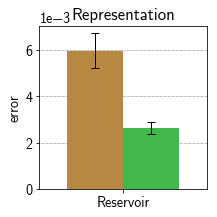

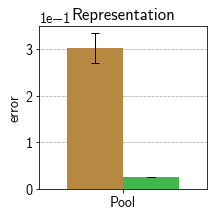

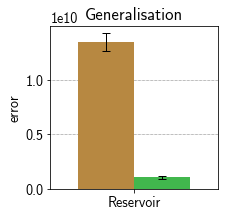

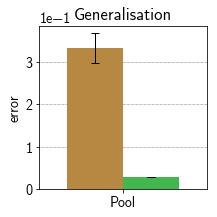

In [120]:
vals = np.array([mseMean['randRepRes'], mseMean['anisoRepRes']])
yerr = np.array([mseStd['randRepRes'], mseStd['anisoRepRes']])

plotRMSE2(vals, yerr, 'Representation', 'Reservoir')

vals = np.array([mseMean['randRepPoo'], mseMean['anisoRepPoo']])
yerr = np.array([mseStd['randRepPoo'], mseStd['anisoRepPoo']])

plotRMSE2(vals, yerr, 'Representation', 'Pool')

vals = np.array([mseMean['randGenRes'], mseMean['anisoGenRes']])
yerr = np.array([mseStd['randGenRes'], mseStd['anisoGenRes']])

plotRMSE2(vals, yerr, 'Generalisation', 'Reservoir')

vals = np.array([mseMean['randGenPoo'], mseMean['anisoGenPoo']])
yerr = np.array([mseStd['randGenPoo'], mseStd['anisoGenPoo']])

plotRMSE2(vals, yerr, 'Generalisation', 'Pool')

randRepRes vs. anisoRepRes: p = 0.0000002326
randRepPoo vs. anisoRepPoo: p = 0.0000000001


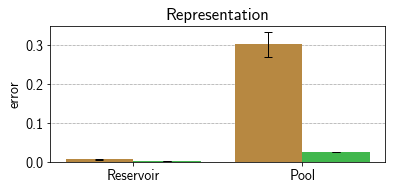

In [67]:
printTtest(mse, 'randRepRes', 'anisoRepRes')
printTtest(mse, 'randRepPoo', 'anisoRepPoo')

vals1 = np.array([mseMean['randRepRes'], mseMean['randRepPoo']])
vals2 = np.array([mseMean['anisoRepRes'], mseMean['anisoRepPoo']])
yerr1 = np.array([mseStd['randRepRes'], mseStd['randRepPoo']])
yerr2 = np.array([mseStd['anisoRepRes'], mseStd['anisoRepPoo']])

plotRMSE(vals1, vals2, yerr1, yerr2, 'Representation')

randGenRes vs. anisoGenRes: p = 0.0000000000
randGenPoo vs. anisoGenPoo: p = 0.0000000001


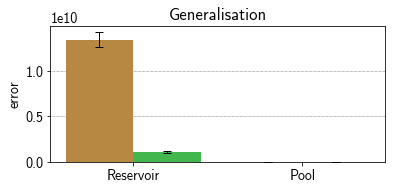

In [89]:
printTtest(mse, 'randGenRes', 'anisoGenRes')
printTtest(mse, 'randGenPoo', 'anisoGenPoo')

vals1 = np.array([mseMean['randGenRes'], mseMean['randGenPoo']])
vals2 = np.array([mseMean['anisoGenRes'], mseMean['anisoGenPoo']])
yerr1 = np.array([mseStd['randGenRes'], mseStd['randGenPoo']])
yerr2 = np.array([mseStd['anisoGenRes'], mseStd['anisoGenPoo']])

plotRMSE(vals1, vals2, yerr1, yerr2, 'Generalisation')

# Generalisation pool

In [50]:
idxT = 0  # choose an index of a trajectory

est = estimates['anisoGenPoo'][idxT]
tgt = targets[idxT]

In [60]:
def getTicks(limits, precision=20):
    # Calc upper and bottom ticks
    b = float(np.ceil(limits[0]*precision)/precision)
    t = float(np.floor(limits[1]*precision)/precision)+0.0000001

    # Arange ticks and return
    return np.arange(b, t, float(1/precision))

def plotMovement1D(tgt, est, color, dim, name, ylim=None):
    plt.figure(figsize=(6,2))
    plt.plot(tgt, linewidth=4.0, color='#D500F9', label='target trajectory')
    plt.plot(est, linewidth=2.0, color=color, alpha=0.9, label='network output')
    plt.plot(savgol_filter(est, 21, 1), alpha=0.9, linewidth=2.0, linestyle='dotted', color='#000000', label='smoothed output')
    if ylim is not None: plt.ylim(ylim)
    plt.xlabel('time steps')
    plt.ylabel(dim+' [m]')
    plt.savefig('plots/figure6/'+name+'-1d-'+dim+'.svg')
    pl = plt.show()
    
def plotMovement3D(tgt, est, color, name, view=(20, 120), xlim=None, ylim=None, zlim=None):
    plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d')
    ax.plot3D(tgt[0], tgt[1], tgt[2], linewidth=4.0, color='#D500F9')
    ax.plot3D(est[0], est[1], est[2], linewidth=2.0, color=color, alpha=0.8)
    ax.plot3D(
        savgol_filter(est[0], 21, 1), savgol_filter(est[1], 21, 1), savgol_filter(est[2], 21, 1),
        linewidth=2.0, linestyle='dotted', color='#000000', alpha=0.9
    )
    
    # Set axis and limits if limits are given
    if xlim is not None:
        ax.set_xticks(getTicks(xlim, precision=40))
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_yticks(getTicks(ylim, precision=40))
        ax.set_ylim(ylim)
    if zlim is not None:
        ax.set_zticks(getTicks(zlim, precision=20))
        ax.set_zlim(zlim)
        
    # Set view perspective
    ax.view_init(*view)
    
    # Set labels
    ax.set_xlabel('x [m]', labelpad=10)
    ax.set_ylabel('y [m]', labelpad=10)
    ax.set_zlabel('z [m]', labelpad=10)
    
    plt.savefig('plots/figure6/'+name+'-3d.svg')
    pl = plt.show()

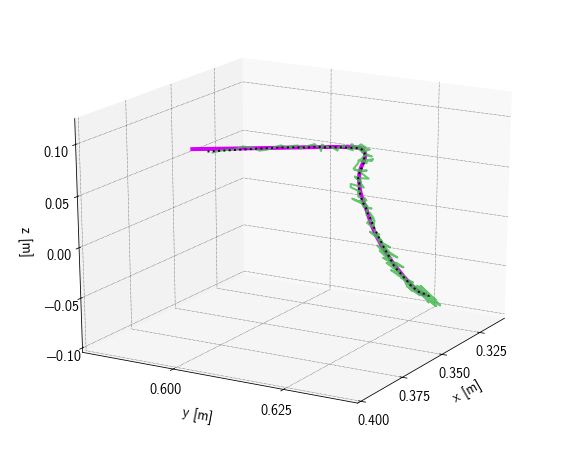

In [61]:
plotMovement3D(tgt, est, p.pltColor3, 'generalisation-aniso-pool',
               view=(20, 30), xlim=(0.31,0.4), ylim=(0.58,0.64), zlim=(-0.1,0.12))

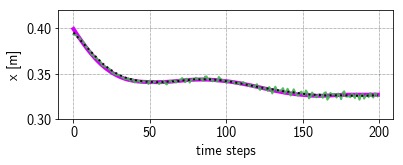

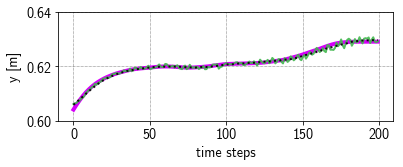

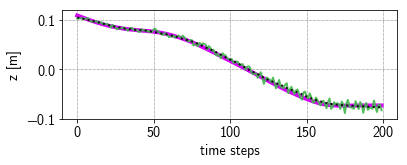

In [336]:
plotMovement1D(tgt[0], est[0], p.pltColor3, 'x', 'generalisation-aniso-pool', ylim=(0.3,0.42))
plotMovement1D(tgt[1], est[1], p.pltColor3, 'y', 'generalisation-aniso-pool', ylim=(0.6,0.64))
plotMovement1D(tgt[2], est[2], p.pltColor3, 'z', 'generalisation-aniso-pool', ylim=(-0.1,0.12))